### Dataset

- [Lamb et al. (2020): Global Whole Lithosphere Isostasy datasets](https://zenodo.org/record/4031646#.X822jXUzZH5)

- [EMC-CAM2016 (Global upper mantle surface wave tomography model)](http://ds.iris.edu/ds/products/emc-cam2016/)

- [CRUST1.0 (A New Global Crustal Model at 1x1 Degrees)](https://igppweb.ucsd.edu/~gabi/crust1.html)

- [ETOPO5 (5 arc-minute global relief model of Earth's surface)](https://www.ngdc.noaa.gov/mgg/global/) [[Download]](https://www.eea.europa.eu/data-and-maps/data/world-digital-elevation-model-etopo5)

- [age.3.6 (Age, spreading rates and spreading asymmetry of the world's ocean crust)](https://www.ngdc.noaa.gov/mgg/ocean_age/data/2008/grids/age/) (Muller et al., 2008)


### Reference:
- Lamb, S., Moore, J. D., Perez‐Gussinye, M., & Stern, T. Global whole lithosphere isostasy: implications for surface elevations, structure, strength and densities of the continental lithosphere. Geochemistry, Geophysics, Geosystems, e2020GC009150.
- Priestley, K., and D. McKenzie (2013), The relationship between shear wave velocity, temperature, attenuation and viscosity in the shallow part of the mantle, Earth and Planetary Science Letters, 381, 78–91. https://doi.org/10.1016/j.epsl.2013.08.022
- Priestley, K. , McKenzie, D. and Ho, T. (2019). A Lithosphere–Asthenosphere Boundary—a Global Model Derived from Multimode Surface‐Wave Tomography and Petrology. In Lithospheric Discontinuities (eds H. Yuan and B. Romanowicz). https://doi.org/10.1002/9781119249740.ch6
- Muller, R. D., M. Sdrolias, C. Gaina, and W. R. Roest (2008), Age, spreading rates, and spreading asymmetry of the world's ocean crust, Geochem. Geophys. Geosyst., 9, Q04006, doi:10.1029/2007GC001743. 


In [1]:
import numpy as np
import litho1pt0 as litho
import stripy
import os
import xarray
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def read_xyzfile(fname,order,dlon,dlat):
    data = np.loadtxt(fname)
    if order == "lonlat":
        lons,lats,z = data[:,0],data[:,1],data[:,2]
    if order == "latlon":
        lats,lons,z = data[:,0],data[:,1],data[:,2]
    minlon,maxlon,minlat,maxlat = lons.min(),lons.max(),lats.min(),lats.max()
    extent = (minlon,maxlon,minlat,maxlat)
    nlon = int((maxlon-minlon)/dlon+1)
    nlat = int((maxlat-minlat)/dlat+1)
    size = nlon*nlat
    data = np.zeros((nlat,nlon))
    for i in range(size):
        lon_idx = np.around((lons[i]-minlon)/dlon).astype("int")
        lat_idx = np.around((lats[i]-maxlat)/dlat).astype("int")
        data[lat_idx,lon_idx]=z[i]
    return data,extent

In [3]:
# parameters for cartopy
rivers    = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
                                       edgecolor='Blue', facecolor="none")
coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '110m',
                                          edgecolor=(0.0,0.0,0.0),facecolor="none")
prj_base  = ccrs.PlateCarree()
#prj_base  = ccrs.Mercator()

# parameters for plot
xticks_global = np.arange(-180,180+10,60)
yticks_global = np.arange(-90,90+10,30)
xticks_area = np.arange(-180,180+5,5)
yticks_area = np.arange(-90,90+5,5)
dpi = 150

order= 3 

outputfile = "output_1_01_01_Lamb2020_WLI_order_"+str(order)+"/"
outputPath = os.path.join(os.path.abspath("."),outputfile) 
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

## Whole lithosphere isostasy

The whole lithosphere isostasy is calculated by: 
$\Delta H = \Delta C/ \alpha - \Delta L /\beta$

Where, 

$\Delta H $ surface elevation above sea level

$\Delta C$ changes in crust thickness

$\Delta L$ changes in lithospheric thickness

$\alpha = \rho_a/(\rho_m-\rho_c)$

$\beta  = \rho_a/(\rho_m-\rho_a)$

In [4]:
fname = "../Data/Lamb2020/ds03.xyz"
dlon_dtopo,dlat_dtopo = 1,1
data_dtopo,extent_dtopo= read_xyzfile(fname,"lonlat",dlon_dtopo,dlat_dtopo)

extent_base = extent_dtopo
dlon_base,dlat_base = dlon_dtopo,dlat_dtopo
shape_base = data_dtopo.shape

/home/nl/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/nl/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)
/home/nl/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not posit

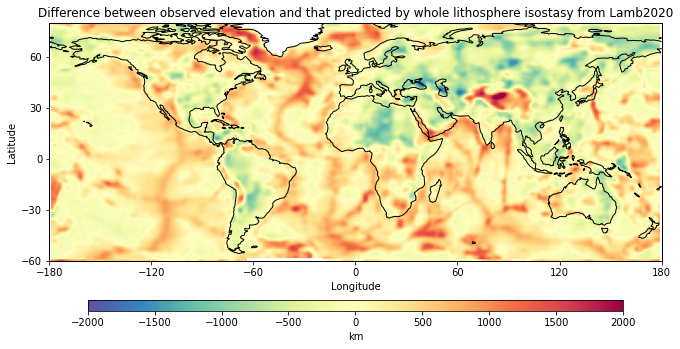

In [5]:
# Fig.8 in Lamb2020
data_img = data_dtopo
extent_img = extent_dtopo
extent_fig = extent_base
fname_fig = "Difference between observed elevation and that predicted by whole lithosphere isostasy from Lamb2020"
cmap_img = cm.Spectral_r

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
ax.set()
#ax.set_global()
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=-2000,vmax=2000,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("km")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

In [6]:
minlon,maxlon,minlat,maxlat = extent_base
nlon = shape_base[1]
nlat = shape_base[0]
size = nlon*nlat
lonv, latv = np.meshgrid(np.linspace(minlon,maxlon,nlon), np.linspace(minlat,maxlat,nlat), indexing='xy')

### 2. Calculation
This is calculated using the following parameters: 

(1) for elevations >−1,000 m α and β (7.8 and 93, respectively)

(2) for oceanic regions with elevations <−1,000, where α and β are 6.5 and 65, respectively; 

(3) a 32 kmreference crustal thickness for 100 km thick conductive lithosphere

(4) crustal thickness and elevations are those in the CRUST 1.0 and Etopo5 databases (Here we use the data from Litho1.0); 

(5) conductive lithosphere thicknesses are those from Priestley et al. (2019).

In [7]:
def interp2grid(extent0,dx0,dy0,data0,extent1,dx1,dy1,order): 
    """
    extent0,dx0,dy0,data0: source data
    extent1,dx1,dy1: target data
    """
    square0  = stripy.cartesian_meshes.square_mesh(extent0, dx0, dy0,refinement_levels=0)
    xmin0, xmax0, ymin0, ymax0 = extent0    
    data = np.zeros(square0.npoints)
    for i in range(square0.npoints):
        x = square0.x[i]
        y = square0.y[i]
        idx = np.around((x-xmin0)/dx0).astype(int)
        idy = np.around((y-ymin0)/dy0).astype(int)
        data[i] = data0[idy,idx]
    
    xmin1, xmax1, ymin1, ymax1 = extent1
    grid_x = np.arange(xmin1, xmax1+dx1/2, dx1)
    grid_y = np.arange(ymin1, ymax1+dy1/2, dy1)
    grid_xcoords, grid_ycoords = np.meshgrid(grid_x, grid_y)
    data1, ierr = square0.interpolate(grid_xcoords.ravel(), grid_ycoords.ravel(), data, order=order)
    nx = grid_x.shape[0]
    ny = grid_y.shape[0]
    data1 = data1.reshape(ny,nx)
    return data1

### 2.1 Surface topography/bathymetry and crustal thickness from Litho1.0

In [8]:
def get_closest_grddata(extent0,dx0,dy0,data0,extent1,dx1,dy1):
    """
    extent0,dx0,dy0,data0: source data
    extent1,dx1,dy1: target data
    """
    xmin0, xmax0, ymin0, ymax0 = extent0 
    x1 = np.arange(extent1[0],extent1[1]+dx1/4,dx1)
    y1 = np.arange(extent1[2],extent1[3]+dy1/4,dy1) 
    
    x0 = np.arange(extent0[0],extent0[1]+dx0/4,dx0)
    y0 = np.arange(extent0[2],extent0[3]+dy0/4,dy0) 
    
    nx1 = len(x1)
    ny1 = len(y1)

    data1 = np.zeros((ny1,nx1))
    xidx = np.zeros(nx1)
    yidx = np.zeros(ny1)
    
    for i in range(nx1):
        xidx[i] = (np.abs(x0 -x1[i])).argmin()
    for j in range(ny1):
        yidx[j] = (np.abs(y0-y1[j])).argmin()
        
    for i in range(nx1):
        for j in range(ny1):
            data1[j,i] = data0[yidx[j].astype(int),xidx[i].astype(int)]
    return data1

In [9]:
from osgeo import gdal
#fname = "../../../data/DEM/ETOPO1_Bed_g_geotiff.tif"
fname = "../Data/ETOPO5.tif"
gtiff = gdal.Open(fname)
width = gtiff.RasterXSize
height = gtiff.RasterYSize
gt = gtiff.GetGeoTransform()
img = np.flipud(gtiff.GetRasterBand(1).ReadAsArray())

In [10]:
minlon,maxlat = gt[0],gt[3]
dlon,dlat = gt[1], -gt[5] #dlon,dlat = 5/60,5/60
nlon,nlat = img.shape[1],img.shape[0]
maxlon = minlon+dlon*nlon
minlat = maxlat-dlat*nlat
extent = (minlon,maxlon,minlat,maxlat)

extent_topo0 = extent
dlon_topo0,dlat_topo0 = dlon,dlat
data_topo0 = img

In [11]:
data_topo = get_closest_grddata(extent_topo0,dlon_topo0,dlat_topo0,data_topo0,extent_base,dlon_base,dlat_base)

In [12]:
# data_topo2 = interp2grid(extent_topo0,dlon_topo0,dlat_topo0,data_topo0,extent_base,dlon_base,dlat_base)

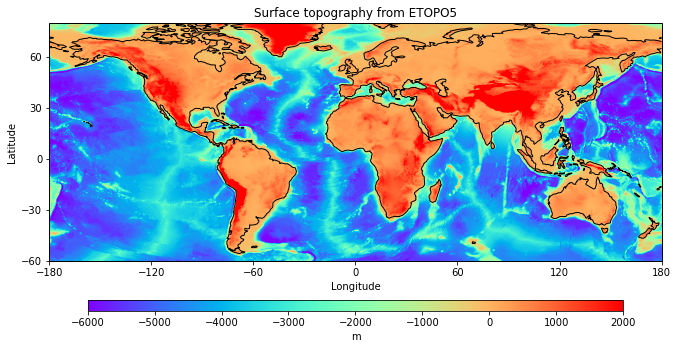

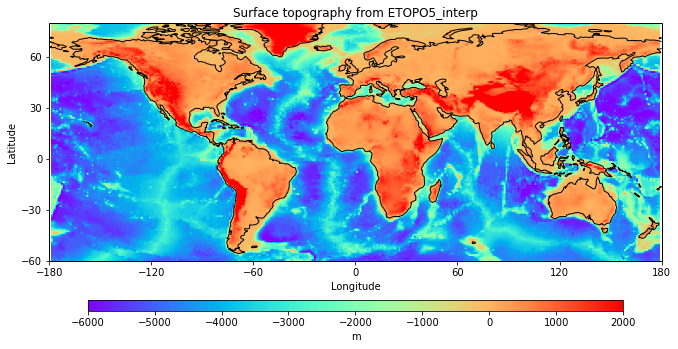

In [14]:
# Fig.2a in Lamb2020
# source data
data_img = data_topo0 
extent_img = extent_topo0
extent_fig = extent_base
fname_fig = "Surface topography from ETOPO5"
cmap_img = cm.rainbow

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=-6000,vmax=2000,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("m")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

# interpolated data
data_img = data_topo 
extent_img = extent_base
extent_fig = extent_base
fname_fig = "Surface topography from ETOPO5_interp"
cmap_img = cm.rainbow

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=-6000,vmax=2000,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("m")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

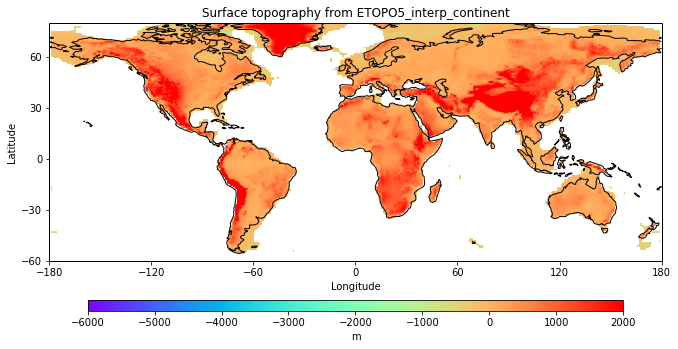

In [15]:
# interpolated data
data_img = data_topo.copy()
data_img[data_topo<=-1000]= np.nan
extent_img = extent_base
extent_fig = extent_base
fname_fig = "Surface topography from ETOPO5_interp_continent"
cmap_img = cm.rainbow

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=-6000,vmax=2000,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("m")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

### 2.2 Crustal thickness from CRUST 1.0 (Laske et al., 2013)

In [16]:
fname = "../Data/crust1.0/crsthk.xyz"
dlon_ct0,dlat_ct0 = 1,1
data_ct0,extent_ct0 = read_xyzfile(fname,"lonlat",dlon_ct0,dlat_ct0)
data_ct = interp2grid(extent_ct0,dlon_ct0,dlat_ct0,data_ct0,extent_base,dlon_base,dlat_base,order)

In [ ]:
fname = "../Data/crust1.0/depthtomoho.xyz"
dlon_moho0,dlat_moho0 = 1,1
data_moho0,extent_moho0 = read_xyzfile(fname,"lonlat",dlon_moho0,dlat_moho0)
data_moho = interp2grid(extent_moho0,dlon_moho0,dlat_moho0,data_moho0,extent_base,dlon_base,dlat_base,order)

In [ ]:
fname = "../Data/crust1.0/sedthk.xyz"
dlon_st0,dlat_st0 = 1,1
data_st0,extent_st0 = read_xyzfile(fname,"lonlat",dlon_st0,dlat_st0)
data_st = interp2grid(extent_st0,dlon_st0,dlat_st0,data_st0,extent_base,dlon_base,dlat_base,order)

In [ ]:
# interpolated data
data_img = data_st
extent_img = extent_base
extent_fig = extent_base
fname_fig = "Sediment thickness from CRUST 1.0 (Laske et al., 2013)_interp"
cmap_img = cm.Spectral_r

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
#ax.set_global()
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=0.,vmax=5,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("km")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
ax.scatter(error_lon,error_lat,color='blue',s=100, transform=prj_base)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

In [ ]:
# Fig.2b in Lamb2020
# source data
data_img = data_ct0
extent_img = extent_ct0
extent_fig = extent_base
fname_fig = "Crustal thickness from CRUST 1.0 (Laske et al., 2013)"
cmap_img = cm.Spectral_r

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
#ax.set_global()
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=5,vmax=60,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("km")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

# interpolated data
data_img = data_ct
extent_img = extent_base
extent_fig = extent_base
fname_fig = "Crustal thickness from CRUST 1.0 (Laske et al., 2013)_interp"
cmap_img = cm.Spectral_r

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
#ax.set_global()
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=5,vmax=60,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("km")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

### 2.3 Conductive lithosphere thickness from Priestley2019

In [ ]:
fname = "../Data/CAM2016/CAM2016Litho/CAM2016Litho"
dlon0,dlat0 = 2,2
data_clt0,extent_clt0 = read_xyzfile(fname,"latlon",dlon0,dlat0)
data_clt = interp2grid(extent_clt0,dlon0,dlat0,data_clt0,extent_base,dlon_base,dlat_base,order)

In [ ]:
# Fig.3c in Lamb2020
# source data
data_img = data_clt0
extent_img = extent_clt0
extent_fig = extent_base
fname_fig = "Conductive lithosphere thickness from Priestley2019"
cmap_img = cm.Spectral

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=0,vmax=250,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("km")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

# interpolated data
data_img = data_clt
extent_img = extent_base
extent_fig = extent_base
fname_fig = "Conductive lithosphere thickness from Priestley2019_interp"
cmap_img = cm.Spectral

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=0,vmax=250,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("km")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
ax.scatter(error_lon,error_lat,color='blue',s=100, transform=prj_base)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

In [ ]:
### Plot of conductive lithosphere against crustal thickness for elevations within 50 m of sea level

fname_fig = "Plot of conductive lithosphere against crustal thickness for elevations within 50 m of sea level"
xticks = np.arange(40,220+5,20)
yticks = np.arange(20,50+5,10) 
extent_fig = ([50,200,20,50])

within_50m = np.abs(data_topo)<50.

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.set(xlabel='Conductive lithosphere thickness km', ylabel='Crustal thickness km',xticks=xticks,yticks=yticks,title=fname_fig)
plt.axis(extent_fig)
ax.scatter(data_clt[within_50m ].flatten(),data_ct[within_50m ].flatten(),s =5, color="red")
#plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

### 2.4 Difference between observed elevation and that predicted by whole lithosphere isostasy

In [ ]:
# cal the WLI (reference parameters from Lamb2020)
is_ocean = data_topo <= -1000.

# 1 for continet, 2 for ocean
alpha1,beta1 = 7.8,93
alpha2,beta2 = 6.5,65
alpha_water =  3250./(3250.-1000.)
ref_c = 32
ref_l = 100

topo_cal1 = (data_ct+data_st-ref_c)/alpha1-(data_clt-ref_l)/beta1
topo_cal2 = ((data_ct+data_st-ref_c)/alpha2-(data_clt-ref_l)/beta2)*alpha_water
#topo_cal2 = (data_ct-ref_c)/alpha2-(data_clt-ref_l)/beta2*alpha_water
#topo_cal3 = ((data_ct+data_st-ref_c)/alpha2-(100.-ref_l)/beta2)*alpha_water


#topo_cal1 = (data_ct-ref_c)/alpha1-(data_clt-ref_l)/beta1
#topo_cal2 = ((data_ct-ref_c)/alpha2-(data_clt-ref_l)/beta2)*alpha_water

clt_lowercutoff = data_clt <50
topo_cal = np.empty_like(topo_cal1)
topo_cal[~is_ocean] = topo_cal1[~is_ocean]
topo_cal[is_ocean]  = topo_cal2[is_ocean] 
#topo_cal[clt_lowercutoff]  = topo_cal3[clt_lowercutoff] 

data_dtopo2 = data_topo-topo_cal*1000
ddtopo = data_dtopo2-data_dtopo

In [ ]:
# Fig.8 in Lamb2020
data_img = data_dtopo2
extent_img = extent_dtopo
extent_fig = extent_dtopo
fname_fig = "Difference between observed elevation and that predicted by whole lithosphere isostasy 2"
cmap_img = cm.Spectral_r

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
#ax.set_global()
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=-2000,vmax=2000,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("m")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

# Fig.8 in Lamb2020
data_img = data_dtopo
extent_img = extent_dtopo
extent_fig = extent_base
fname_fig = "Difference between observed elevation and that predicted by whole lithosphere isostasy from Lamb2020"
cmap_img = cm.Spectral_r

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
ax.set()
#ax.set_global()
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=-2000,vmax=2000,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("km")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

In [ ]:
# interpolated data
data_img = ddtopo.copy()
data_img[np.abs(ddtopo)<250.] = np.nan
extent_img = extent_base
extent_fig = extent_base
fname_fig = "Difference between dtopo (remove np.abs(ddtopo) < 250m)"
cmap_img = cm.rainbow

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=-1000,vmax=1000,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("m")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

### Ocean age for mask

In [ ]:
fname = "../Data/age.3.6.nc"
data_age0 = xarray.open_dataset(fname)
data_age1 = data_age0.sel(x=slice(-180,180, 10), y=slice(-90, 90, 10))

lons = data_age1.coords.get('x')
lats = data_age1.coords.get('y')
vals = data_age1['z']
age = vals.data * 0.01 
age[np.isnan(age)] = -1.0


# x,y = np.meshgrid(lons.data, lats.data)
# age = vals.data * 0.01 
# age[np.isnan(age)] = -1.0
extent_age1 = (lons.min(),lons.max(),lats.min(),lats.max())
dlon_age1,dlat_age1 = 1,1 

In [ ]:
data_age = interp2grid(extent_age1,dlon_age1,dlat_age1,age,extent_base,dlon_base,dlat_base,order)

In [ ]:
# interpolated data
data_img = data_age.copy()
data_img[~is_ocean] =np.nan
extent_img = extent_base
extent_fig = extent_base
fname_fig = "Ocean age_interp"
cmap_img = cm.RdYlBu

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=0,vmax=180,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("ma")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

In [ ]:
is_midocean = data_age<10

data_img = data_age.copy()
data_img[~is_midocean] = np.nan
data_img[~is_ocean] = np.nan
extent_img = extent_base
extent_fig = extent_base
fname_fig = "Ocean age"
cmap_img = cm.Spectral

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=0,vmax=200,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("ma")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

In [ ]:
# interpolated data
data_img = ddtopo.copy()
data_img[~is_ocean]=np.nan
data_img[~is_midocean]=np.nan
data_img[np.abs(ddtopo)<250.] = np.nan
extent_img = extent_base
extent_fig = extent_base
fname_fig = "Difference between dtopo (remove np.abs(ddtopo) < 250m)"
cmap_img = cm.rainbow

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_extent(extent_fig)
m=ax.imshow(data_img, origin='lower',cmap=cmap_img,vmin=-1000,vmax=1000,extent=extent_img, transform=prj_base)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.12,shrink=0.8, aspect=50)
cbr.set_label("m")
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=5)
#plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')